# The implementation of gradient descend in python
Today we are going to do lab with gradient descent from coursera course with Andrew Ng uwu. 



## Tools
In this lab, we will make use of:

- NumPy, a popular library for scientific computing
- Matplotlib, a popular library for plotting data
- plotting routines in the lab_utils.py file in the local directory

In [120]:
import math, copy
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')
from lab_utils_uni import plt_house_x, plt_contour_wgrad, plt_divergence, plt_gradients
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap
from ipywidgets import interact
from lab_utils_common import compute_cost
from lab_utils_common import dlblue, dlorange, dldarkred, dlmagenta, dlpurple, dlcolors


## code from the lib uni liblary from og lab from course

In [121]:
### this is a code from liblary lab_utils_uni.py for plt_gradients
def plt_gradients(x_train,y_train, f_compute_cost, f_compute_gradient):
    #===============
    #  First subplot
    #===============
    fig,ax = plt.subplots(1,2,figsize=(12,4))

    # Print w vs cost to see minimum
    fix_b = 100
    w_array = np.linspace(-100, 500, 50)
    w_array = np.linspace(0, 400, 50)
    cost = np.zeros_like(w_array)

    for i in range(len(w_array)):
        tmp_w = w_array[i]
        cost[i] = f_compute_cost(x_train, y_train, tmp_w, fix_b)
    ax[0].plot(w_array, cost,linewidth=1)
    ax[0].set_title("Cost vs w, with gradient; b set to 100")
    ax[0].set_ylabel('Cost')
    ax[0].set_xlabel('w')

    # plot lines for fixed b=100
    for tmp_w in [100,200,300]:
        fix_b = 100
        dj_dw,dj_db = f_compute_gradient(x_train, y_train, tmp_w, fix_b )
        j = f_compute_cost(x_train, y_train, tmp_w, fix_b)
        add_line(dj_dw, tmp_w, j, 30, ax[0])

    #===============
    # Second Subplot
    #===============

    tmp_b,tmp_w = np.meshgrid(np.linspace(-200, 200, 10), np.linspace(-100, 600, 10))
    U = np.zeros_like(tmp_w)
    V = np.zeros_like(tmp_b)
    for i in range(tmp_w.shape[0]):
        for j in range(tmp_w.shape[1]):
            U[i][j], V[i][j] = f_compute_gradient(x_train, y_train, tmp_w[i][j], tmp_b[i][j] )
    X = tmp_w
    Y = tmp_b
    n=-2
    color_array = np.sqrt(((V-n)/2)**2 + ((U-n)/2)**2)

    ax[1].set_title('Gradient shown in quiver plot')
    Q = ax[1].quiver(X, Y, U, V, color_array, units='width', )
    ax[1].quiverkey(Q, 0.9, 0.9, 2, r'$2 \frac{m}{s}$', labelpos='E',coordinates='figure')
    ax[1].set_xlabel("w"); ax[1].set_ylabel("b")
    
def plt_divergence(p_hist, J_hist, x_train,y_train):

    x=np.zeros(len(p_hist))
    y=np.zeros(len(p_hist))
    v=np.zeros(len(p_hist))
    for i in range(len(p_hist)):
        x[i] = p_hist[i][0]
        y[i] = p_hist[i][1]
        v[i] = J_hist[i]

    fig = plt.figure(figsize=(12,5))
    plt.subplots_adjust( wspace=0 )
    gs = fig.add_gridspec(1, 5)
    fig.suptitle(f"Cost escalates when learning rate is too large")
    #===============
    #  First subplot
    #===============
    ax = fig.add_subplot(gs[:2], )

    # Print w vs cost to see minimum
    fix_b = 100
    w_array = np.arange(-70000, 70000, 1000, dtype="int64")
    cost = np.zeros_like(w_array,float)

    for i in range(len(w_array)):
        tmp_w = w_array[i]
        cost[i] = compute_cost(x_train, y_train, tmp_w, fix_b)

    ax.plot(w_array, cost)
    ax.plot(x,v, c='magenta')
    ax.set_title("Cost vs w, b set to 100")
    ax.set_ylabel('Cost')
    ax.set_xlabel('w')
    ax.xaxis.set_major_locator(MaxNLocator(2))

    #===============
    # Second Subplot
    #===============

    tmp_b,tmp_w = np.meshgrid(np.arange(-35000, 35000, 500),np.arange(-70000, 70000, 500))
    tmp_b = tmp_b.astype('int64')
    tmp_w = tmp_w.astype('int64')
    z=np.zeros_like(tmp_b,float)
    for i in range(tmp_w.shape[0]):
        for j in range(tmp_w.shape[1]):
            z[i][j] = compute_cost(x_train, y_train, tmp_w[i][j], tmp_b[i][j] )

    ax = fig.add_subplot(gs[2:], projection='3d')
    ax.plot_surface(tmp_w, tmp_b, z,  alpha=0.3, color='blue')
    ax.xaxis.set_major_locator(MaxNLocator(2))
    ax.yaxis.set_major_locator(MaxNLocator(2))

    ax.set_xlabel('w', fontsize=16)
    ax.set_ylabel('b', fontsize=16)
    ax.set_zlabel('\ncost', fontsize=16)
    plt.title('Cost vs (b, w)')
    # Customize the view angle
    ax.view_init(elev=20., azim=-65)
    ax.plot(x, y, v,c='magenta')

    return   

def inbounds(a,b,xlim,ylim):
    xlow,xhigh = xlim
    ylow,yhigh = ylim
    ax, ay = a
    bx, by = b
    if (ax > xlow and ax < xhigh) and (bx > xlow and bx < xhigh) \
        and (ay > ylow and ay < yhigh) and (by > ylow and by < yhigh):
        return True
    return False 

def plt_contour_wgrad(x, y, hist, ax, w_range=[-100, 500, 5], b_range=[-500, 500, 5],
                contours = [0.1,50,1000,5000,10000,25000,50000],
                      resolution=5, w_final=200, b_final=100,step=10 ):
    b0,w0 = np.meshgrid(np.arange(*b_range),np.arange(*w_range))
    z=np.zeros_like(b0)
    for i in range(w0.shape[0]):
        for j in range(w0.shape[1]):
            z[i][j] = compute_cost(x, y, w0[i][j], b0[i][j] )

    CS = ax.contour(w0, b0, z, contours, linewidths=2,
                   colors=['blue', 'orange', 'darkred', 'magenta', 'purple'])
    ax.clabel(CS, inline=1, fmt='%1.0f', fontsize=10)
    ax.set_xlabel("w");  ax.set_ylabel("b")
    ax.set_title('Contour plot of cost J(w,b), vs b,w with path of gradient descent')
    w = w_final; b=b_final
    ax.hlines(b, ax.get_xlim()[0],w, lw=2, color='purple', ls='dotted')
    ax.vlines(w, ax.get_ylim()[0],b, lw=2, color='purple', ls='dotted')

    base = hist[0]
    for point in hist[0::step]:
        edist = np.sqrt((base[0] - point[0])**2 + (base[1] - point[1])**2)
        if(edist > resolution or point==hist[-1]):
            if inbounds(point,base, ax.get_xlim(),ax.get_ylim()):
                plt.annotate('', xy=point, xytext=base,xycoords='data',
                         arrowprops={'arrowstyle': '->', 'color': 'r', 'lw': 3},
                         va='center', ha='center')
            base=point
    return

    
# draw derivative line
# y = m*(x - x1) + y1
def add_line(dj_dx, x1, y1, d, ax):
    x = np.linspace(x1-d, x1+d,50)
    y = dj_dx*(x - x1) + y1
    ax.scatter(x1, y1, color="blue", s=50)
    ax.plot(x, y, '--', c="red",zorder=10, linewidth = 1)
    xoff = 30 if x1 == 200 else 10
    ax.annotate(r"$\frac{\partial J}{\partial w}$ =%d" % dj_dx, fontsize=14,
                xy=(x1, y1), xycoords='data',
            xytext=(xoff, 10), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"),
            horizontalalignment='left', verticalalignment='top')
    
# Loop version of multi-variable compute_cost
def compute_cost(X, y, w, b):
    """
    compute cost
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
    Returns
      cost (scalar)    : cost
    """
    m = X.shape[0]
    cost = 0.0
    for i in range(m):
        f_wb_i = np.dot(X[i],w) + b           #(n,)(n,)=scalar
        cost = cost + (f_wb_i - y[i])**2
    cost = cost/(2*m)
    return cost 

def compute_gradient(X, y, w, b):
    """
    Computes the gradient for linear regression
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
    Returns
      dj_dw (ndarray Shape (n,)): The gradient of the cost w.r.t. the parameters w.
      dj_db (scalar):             The gradient of the cost w.r.t. the parameter b.
    """
    m,n = X.shape           #(number of examples, number of features)
    dj_dw = np.zeros((n,))
    dj_db = 0.

    for i in range(m):
        err = (np.dot(X[i], w) + b) - y[i]
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err * X[i,j]
        dj_db = dj_db + err
    dj_dw = dj_dw/m
    dj_db = dj_db/m

    return dj_db,dj_dw

    
    

## target
Again we are going to predict the prices of houses basing on given size and price
**Our Data**:  a house with 1000 square feet sold for $300,000 and a house with 2000 square feet sold for $500,000.
## Load our data in to code 

In [122]:
# Load our data set
x_train = np.array([1.0, 2.0])   #features (size as 1000sqft)
y_train = np.array([300.0, 500.0])   #target value (prise as 1000s of $)



## Cost function
in last lab we already made one. 

In [123]:
#Function to calculate the cost
def compute_cost(x, y, w, b):
   
    m = x.shape[0] 
    cost = 0
    
    for i in range(m):
        f_wb = w * x[i] + b
        cost = cost + (f_wb - y[i])**2
    total_cost = 1 / (2 * m) * cost

    return total_cost

In this part andrew ng put some of the unrendered latex code 
So far in this course, you have developed a linear model that predicts $f_{w,b}(x^{(i)})$:
$$f_{w,b}(x^{(i)}) = wx^{(i)} + b \tag{1}$$
In linear regression, you utilize input training data to fit the parameters $w$,$b$ by minimizing a measure of the error between our predictions $f_{w,b}(x^{(i)})$ and the actual data $y^{(i)}$. The measure is called the $cost$, $J(w,b)$. In training you measure the cost over all of our training samples $x^{(i)},y^{(i)}$
$$J(w,b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})^2\tag{2}$$ 
In course *gradient descent* was described as:

$$\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline
\;  w &= w -  \alpha \frac{\partial J(w,b)}{\partial w} \tag{3}  \; \newline 
 b &= b -  \alpha \frac{\partial J(w,b)}{\partial b}  \newline \rbrace
\end{align*}$$
where, parameters $w$, $b$ are updated simultaneously.  

The gradient is defined as:
$$
\begin{align}
\frac{\partial J(w,b)}{\partial w}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})x^{(i)} \tag{4}\\
  \frac{\partial J(w,b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)}) \tag{5}\\
\end{align}
$$
Here *simultaniously* means that we calculate the partial derivatives for all the parameters before updating any of the parameters.

## Implemen Gradient Descent
 To do this we need:
- compute_gradient implementing equation (4) and (5) above
- compute_cost implementing equation (2) above (code from previous lab)
- gradient_descent, utilizing compute_gradient and compute_cost

Conventions:

The naming of python variables containing partial derivatives follows this pattern,$\frac{\partial J(w,b)}{\partial b}$ will be dj_db.
w.r.t is With Respect To, as in partial derivative of $J(wb)$ With Respect To $b$.

### compute_gradient
**compute_gradient** implements (4) and (5) above and returns $\frac{\partial J(w,b)}{\partial w}$,$\frac{\partial J(w,b)}{\partial b}$. The embedded comments describe the operations.

In [124]:
# the way of this code looks scares me 
def compute_gradient(x, y, w, b): 
    """
    Computes the gradient for linear regression 
    Args:
      x (ndarray (m,)): Data, m examples 
      y (ndarray (m,)): target values
      w,b (scalar)    : model parameters  
    Returns
      dj_dw (scalar): The gradient of the cost w.r.t. the parameters w
      dj_db (scalar): The gradient of the cost w.r.t. the parameter b     
     """
    
    # Number of training examples
    m = x.shape[0]    
    dj_dw = 0
    dj_db = 0
    
    for i in range(m):  
        f_wb = w * x[i] + b 
        dj_dw_i = (f_wb - y[i]) * x[i] 
        dj_db_i = f_wb - y[i] 
        dj_db += dj_db_i
        dj_dw += dj_dw_i 
    dj_dw = dj_dw / m 
    dj_db = dj_db / m 
        
    return dj_dw, dj_db

The lectures described how gradient descent utilizes the partial derivative of the cost with respect to a parameter at a point to update that parameter.
Let's use our compute_gradient function to find and plot some partial derivatives of our cost function relative to one of the parameters, $w_0$.
[image](images/C1_W1_Lab03_lecture_slopes.png)


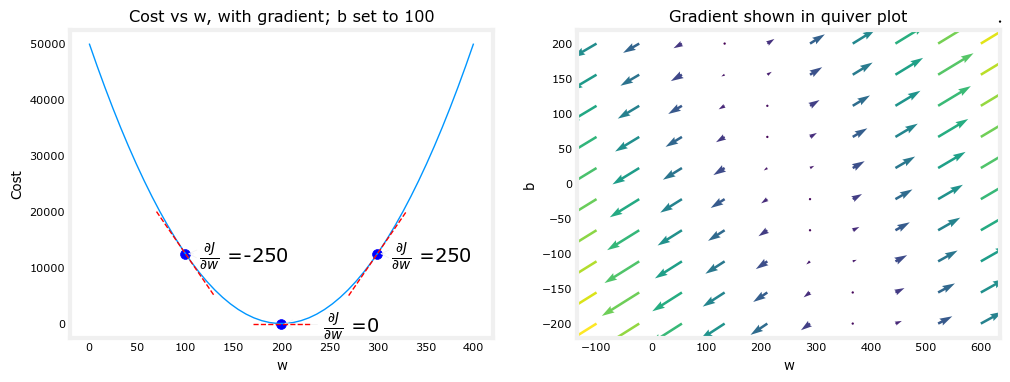

In [125]:
plt_gradients(x_train,y_train, compute_cost, compute_gradient)
plt.show()

Above, the left plot shows $\frac{\partial J(w,b)}{\partial w}$ or the slope of the cost curve relative to $w$ at three points. On the right side of the plot, the derivative is positive, while on the left it is negative. Due to the 'bowl shape', the derivatives will always lead gradient descent toward the bottom where the gradient is zero.

The left plot has fixed $b=100$. Gradient descent will utilize both $\frac{\partial J(w,b)}{\partial w}$ and $\frac{\partial J(w,b)}{\partial b}$ to update parameters. The 'quiver plot' on the right provides a means of viewing the gradient of both parameters. The arrow sizes reflect the magnitude of the gradient at that point. The direction and slope of the arrow reflects the ratio of $\frac{\partial J(w,b)}{\partial w}$ and $\frac{\partial J(w,b)}{\partial b}$ at that point. Note that the gradient points away from the minimum. Review equation (3) above. The scaled gradient is subtracted from the current value of $w$ or $b$. This moves the parameter in a direction that will reduce cost.

Above, the left plot shows $\frac{\partial J(w,b)}{\partial w}$ or the slope of the cost curve relative to $w$ at three points. On the right side of the plot, the derivative is positive, while on the left it is negative. Due to the 'bowl shape', the derivatives will always lead gradient descent toward the bottom where the gradient is zero.

The left plot has fixed $b=100$. Gradient descent will utilize both $\frac{\partial J(w,b)}{\partial w}$ and $\frac{\partial J(w,b)}{\partial b}$ to update parameters. The 'quiver plot' on the right provides a means of viewing the gradient of both parameters. The arrow sizes reflect the magnitude of the gradient at that point. The direction and slope of the arrow reflects the ratio of $\frac{\partial J(w,b)}{\partial w}$ and $\frac{\partial J(w,b)}{\partial b}$ at that point. Note that the gradient points away from the minimum. Review equation (3) above. The scaled gradient is subtracted from the current value of $w$ or $b$. This moves the parameter in a direction that will reduce cost.


## Gradient Descent
Andrew tells us that now is the moment when we can implement it in gradient_descent fuinction. The details of the imprelemntation are in code from lab.  function is below


In [126]:
def gradient_descent(x, y, w_in, b_in, alpha, num_iters, cost_function, gradient_function): 
    """
    Performs gradient descent to fit w,b. Updates w,b by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      x (ndarray (m,))  : Data, m examples 
      y (ndarray (m,))  : target values
      w_in,b_in (scalar): initial values of model parameters  
      alpha (float):     Learning rate
      num_iters (int):   number of iterations to run gradient descent
      cost_function:     function to call to produce cost
      gradient_function: function to call to produce gradient
      
    Returns:
      w (scalar): Updated value of parameter after running gradient descent
      b (scalar): Updated value of parameter after running gradient descent
      J_history (List): History of cost values
      p_history (list): History of parameters [w,b] 
      """
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    p_history = []
    b = b_in
    w = w_in
    
    for i in range(num_iters):
        # Calculate the gradient and update the parameters using gradient_function
        dj_dw, dj_db = gradient_function(x, y, w , b)     

        # Update Parameters using equation (3) above
        b = b - alpha * dj_db                            
        w = w - alpha * dj_dw                            

        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_history.append( cost_function(x, y, w , b))
            p_history.append([w,b])
        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0:
            print(f"Iteration {i:4}: Cost {J_history[-1]:0.2e} ",
                  f"dj_dw: {dj_dw: 0.3e}, dj_db: {dj_db: 0.3e}  ",
                  f"w: {w: 0.3e}, b:{b: 0.5e}")
 
    return w, b, J_history, p_history #return w and J,w history for graphing

In [127]:
# initialize parameters
w_init = 0
b_init = 0
# some gradient descent settings
iterations = 10000
tmp_alpha = 1.0e-2
# run gradient descent
w_final, b_final, J_hist, p_hist = gradient_descent(x_train ,y_train, w_init, b_init, tmp_alpha, 
                                                    iterations, compute_cost, compute_gradient)
print(f"(w,b) found by gradient descent: ({w_final:8.4f},{b_final:8.4f})")

Iteration    0: Cost 7.93e+04  dj_dw: -6.500e+02, dj_db: -4.000e+02   w:  6.500e+00, b: 4.00000e+00
Iteration 1000: Cost 3.41e+00  dj_dw: -3.712e-01, dj_db:  6.007e-01   w:  1.949e+02, b: 1.08228e+02
Iteration 2000: Cost 7.93e-01  dj_dw: -1.789e-01, dj_db:  2.895e-01   w:  1.975e+02, b: 1.03966e+02
Iteration 3000: Cost 1.84e-01  dj_dw: -8.625e-02, dj_db:  1.396e-01   w:  1.988e+02, b: 1.01912e+02
Iteration 4000: Cost 4.28e-02  dj_dw: -4.158e-02, dj_db:  6.727e-02   w:  1.994e+02, b: 1.00922e+02
Iteration 5000: Cost 9.95e-03  dj_dw: -2.004e-02, dj_db:  3.243e-02   w:  1.997e+02, b: 1.00444e+02
Iteration 6000: Cost 2.31e-03  dj_dw: -9.660e-03, dj_db:  1.563e-02   w:  1.999e+02, b: 1.00214e+02
Iteration 7000: Cost 5.37e-04  dj_dw: -4.657e-03, dj_db:  7.535e-03   w:  1.999e+02, b: 1.00103e+02
Iteration 8000: Cost 1.25e-04  dj_dw: -2.245e-03, dj_db:  3.632e-03   w:  2.000e+02, b: 1.00050e+02
Iteration 9000: Cost 2.90e-05  dj_dw: -1.082e-03, dj_db:  1.751e-03   w:  2.000e+02, b: 1.00024e+02


- The cost starts large and rapidly declines as described in the slide from the lecture.
- The partial derivatives, `dj_dw`, and `dj_db` also get smaller, rapidly at first and then more slowly. As shown in the diagram from the lecture, as the process nears the 'bottom of the bowl' progress is slower due to the smaller value of the derivative at that point.
- progress slows though the learning rate, alpha, remains fixed

**Cost should always decrease for successful runs.**
>The change in cost is so rapid initially, it is useful to plot the initial decent on a different scale than the final descent. In the plots below, note the scale of cost on the axes and the iteration step.

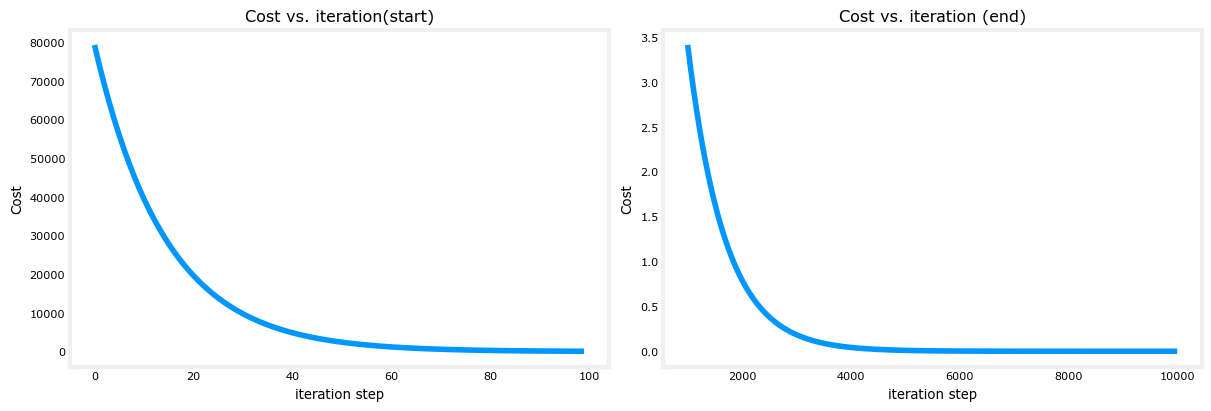

In [128]:
# plot cost versus iteration  
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12,4))
ax1.plot(J_hist[:100])
ax2.plot(1000 + np.arange(len(J_hist[1000:])), J_hist[1000:])
ax1.set_title("Cost vs. iteration(start)");  ax2.set_title("Cost vs. iteration (end)")
ax1.set_ylabel('Cost')            ;  ax2.set_ylabel('Cost') 
ax1.set_xlabel('iteration step')  ;  ax2.set_xlabel('iteration step') 
plt.show()

## Prediction
Not we have optimal values for the $w$ and $b$ parameters, we can use this model to predict other hausing values basing on our learned parameters, as we predict the values should be similar to our data for the same house. 

In [129]:
print(f"1000 sqft house prediction {w_final*1.0 + b_final:0.1f} Thousand dollars")
print(f"1200 sqft house prediction {w_final*1.2 + b_final:0.1f} Thousand dollars")
print(f"2000 sqft house prediction {w_final*2.0 + b_final:0.1f} Thousand dollars")

1000 sqft house prediction 300.0 Thousand dollars
1200 sqft house prediction 340.0 Thousand dollars
2000 sqft house prediction 500.0 Thousand dollars


Now we can show the gradient descent during its execution  by ploting totheter soct and interations

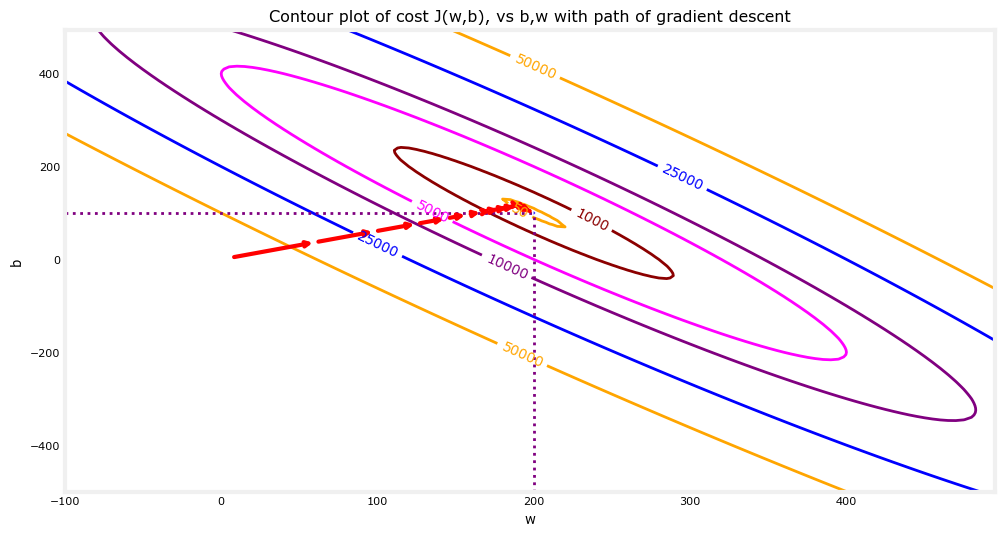

In [130]:
fig, ax = plt.subplots(1,1, figsize=(12, 6))
plt_contour_wgrad(x_train, y_train, p_hist, ax)

Above, the contour plot shows the $cost(w,b)$ over a range of $w$ and $b$. Cost levels are represented by the rings. Overlayed, using red arrows, is the path of gradient descent. Here are some things to note:
- The path makes steady (monotonic) progress toward its goal.
- initial steps are much larger than the steps near the goal.

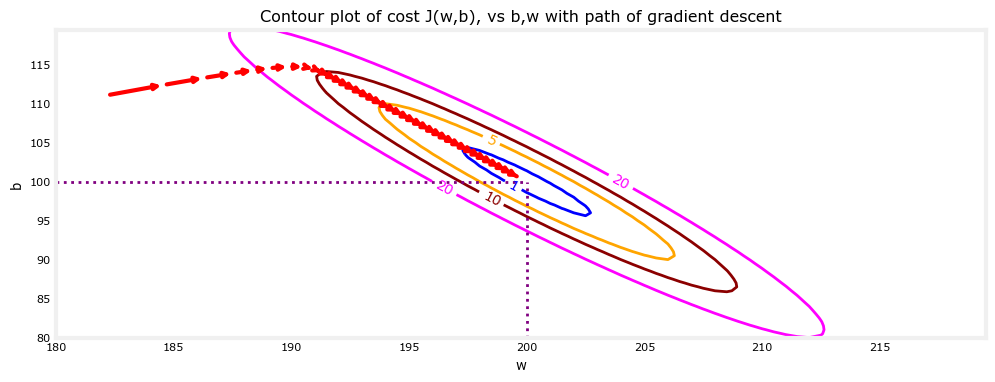

In [131]:
fig, ax = plt.subplots(1,1, figsize=(12, 4))
plt_contour_wgrad(x_train, y_train, p_hist, ax, w_range=[180, 220, 0.5], b_range=[80, 120, 0.5],
            contours=[1,5,10,20],resolution=0.5)

## Increased learning rate
In the lecture, we talked about choosing the right learning rate, 𝛼, in equation (3). If 𝛼 is bigger, gradient descent will converge faster. But if it’s too big, it can actually diverge. The example above shows it converging well.

In [132]:
# initialize parameters
w_init = 0
b_init = 0
# set alpha to a large value
iterations = 10
tmp_alpha = 8.0e-1
# run gradient descent
w_final, b_final, J_hist, p_hist = gradient_descent(x_train ,y_train, w_init, b_init, tmp_alpha, 
                                                    iterations, compute_cost, compute_gradient)

Iteration    0: Cost 2.58e+05  dj_dw: -6.500e+02, dj_db: -4.000e+02   w:  5.200e+02, b: 3.20000e+02
Iteration    1: Cost 7.82e+05  dj_dw:  1.130e+03, dj_db:  7.000e+02   w: -3.840e+02, b:-2.40000e+02
Iteration    2: Cost 2.37e+06  dj_dw: -1.970e+03, dj_db: -1.216e+03   w:  1.192e+03, b: 7.32800e+02
Iteration    3: Cost 7.19e+06  dj_dw:  3.429e+03, dj_db:  2.121e+03   w: -1.551e+03, b:-9.63840e+02
Iteration    4: Cost 2.18e+07  dj_dw: -5.974e+03, dj_db: -3.691e+03   w:  3.228e+03, b: 1.98886e+03
Iteration    5: Cost 6.62e+07  dj_dw:  1.040e+04, dj_db:  6.431e+03   w: -5.095e+03, b:-3.15579e+03
Iteration    6: Cost 2.01e+08  dj_dw: -1.812e+04, dj_db: -1.120e+04   w:  9.402e+03, b: 5.80237e+03
Iteration    7: Cost 6.09e+08  dj_dw:  3.156e+04, dj_db:  1.950e+04   w: -1.584e+04, b:-9.80139e+03
Iteration    8: Cost 1.85e+09  dj_dw: -5.496e+04, dj_db: -3.397e+04   w:  2.813e+04, b: 1.73730e+04
Iteration    9: Cost 5.60e+09  dj_dw:  9.572e+04, dj_db:  5.916e+04   w: -4.845e+04, b:-2.99567e+04


Above, 𝑤 and 𝑏 are oscillating between positive and negative values, with their absolute values increasing with each iteration. Additionally, with each iteration, $\frac{∂𝐽(𝑤,𝑏)}{(∂𝑤)}$ changes sign, and the cost is increasing instead of decreasing. This clearly indicates that the learning rate is too high, causing the solution to diverge.

**Diverge** just means things are going in the wrong direction. Instead of getting closer to the solution, the values are moving further away from it. This happens when the learning rate is too big, causing the algorithm to jump too far every time. As a result, it overshoots the target and keeps getting worse, rather than getting better and settling on a solution.

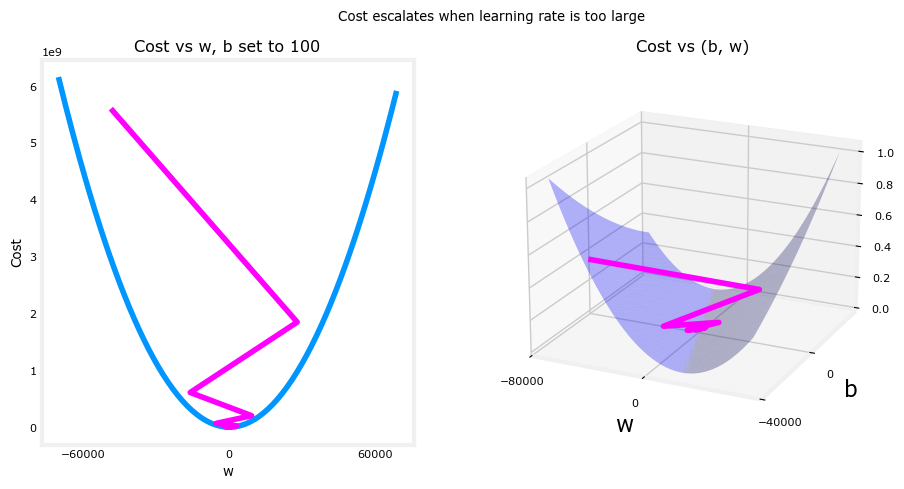

In [133]:
plt_divergence(p_hist, J_hist,x_train, y_train)
plt.show()

Above, the graph on the left shows how 𝑤 changes during the first few steps of gradient descent. You can see 𝑤 bouncing between positive and negative, and the cost is shooting up fast. Since gradient descent is working on both 𝑤 and 𝑏 at the same time, the full story is shown in the 3-D plot on the right.